In [23]:
from src.config import DEFAULT_DATA_FOLDER
from src.models.lstm.utils import determine_labels

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Bidirectional
from typing import Union, Tuple, List

from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

import matplotlib.pyplot as plt

In [24]:
DATASET_PATH = f"{DEFAULT_DATA_FOLDER}/output/combined_posts_results.xlsx"
dataset = pd.read_excel(DATASET_PATH)

In [25]:
# Load pre-trained Word2Vec embeddings (example)
word2vec_path = f'{DEFAULT_DATA_FOLDER}/word-embedding/SO_vectors_200.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [26]:
# labels the columns
dataset['category'] = dataset.apply(determine_labels, axis=1)
dataset['clean_text'] = dataset['clean_text'].fillna('').astype(str)

label_encoder: LabelEncoder = LabelEncoder()
dataset['category'] = label_encoder.fit_transform(dataset['category'])
num_classes: int = len(label_encoder.classes_)

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['clean_text'], dataset['category'], test_size=0.2,
                                                    random_state=42)

In [28]:
# Tokenize and pad sequences
max_num_words: int = dataset['clean_text'].str.len().max()
print("Max number of words: ", max_num_words)
max_sequence_length: int = 250
tokenizer: Tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

Max number of words:  16317


In [29]:
X_train_padded: np.ndarray = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded: np.ndarray = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Convert labels to categorical
y_train_categorical: np.ndarray = to_categorical(y_train, num_classes=num_classes)
y_test_categorical: np.ndarray = to_categorical(y_test, num_classes=num_classes)

In [30]:
sequences = tokenizer.texts_to_sequences(dataset['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
labels_categorical: np.ndarray = to_categorical(dataset['category'], num_classes=num_classes)

In [31]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
accuracies: List[float] = []

for train_index, test_index in skf.split(padded_sequences, dataset['category']):
    print(f'Training on fold {fold_no}...')

    # Split the data into training and testing sets
    X_train, X_test = padded_sequences[train_index], padded_sequences[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    # Build the LSTM model
    # embedding_dim: int = 100
    embedding_dim = word2vec_model.vector_size
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))  # word_index: your vocabulary index
    
    for word, i in word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

    model: Sequential = Sequential()
    
    # Build the LSTM model with pre-trained embeddings
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=False))  # Set trainable=False to use pre-trained embeddings
    
    # model.add(Embedding(input_dim=max_num_words, output_dim=embedding_dim))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Define early stopping callback
    # early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
    # 
    # # Train the model with early stopping
    # history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1,
    #                     callbacks=[early_stopping], verbose=2)

    history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1,
                     verbose=2)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Accuracy for fold {fold_no}: {accuracy}')
    accuracies.append(accuracy)

    fold_no += 1

Training on fold 1...
Epoch 1/40
61/61 - 12s - 191ms/step - accuracy: 0.6170 - loss: 1.0046 - val_accuracy: 0.9860 - val_loss: 0.2188
Epoch 2/40
61/61 - 10s - 170ms/step - accuracy: 0.7011 - loss: 0.7653 - val_accuracy: 0.9721 - val_loss: 0.1545
Epoch 3/40
61/61 - 11s - 184ms/step - accuracy: 0.7400 - loss: 0.6714 - val_accuracy: 0.9442 - val_loss: 0.1861
Epoch 4/40
61/61 - 12s - 196ms/step - accuracy: 0.7639 - loss: 0.6156 - val_accuracy: 0.9767 - val_loss: 0.1255
Epoch 5/40
61/61 - 13s - 209ms/step - accuracy: 0.7878 - loss: 0.5545 - val_accuracy: 0.9721 - val_loss: 0.1206
Epoch 6/40
61/61 - 12s - 195ms/step - accuracy: 0.8142 - loss: 0.5013 - val_accuracy: 0.9302 - val_loss: 0.2103
Epoch 7/40
61/61 - 12s - 204ms/step - accuracy: 0.8334 - loss: 0.4480 - val_accuracy: 0.9674 - val_loss: 0.0961
Epoch 8/40
61/61 - 12s - 203ms/step - accuracy: 0.8412 - loss: 0.4270 - val_accuracy: 0.9628 - val_loss: 0.1373
Epoch 9/40
61/61 - 12s - 195ms/step - accuracy: 0.8516 - loss: 0.3928 - val_accura

In [32]:
# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f'Average Test Accuracy: {average_accuracy}')

Average Test Accuracy: 0.7474789917469025


In [33]:
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 250, 200)       │     4,967,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_34            │ (None, 250, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 200)            │       240,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,691,814 (21.71 MB)

 Trainable params: 241,604 (943.77 KB)

 Non-trainable params: 4,967,000 (18.95 MB)

 Optimizer params: 483,210 (1.84 MB)

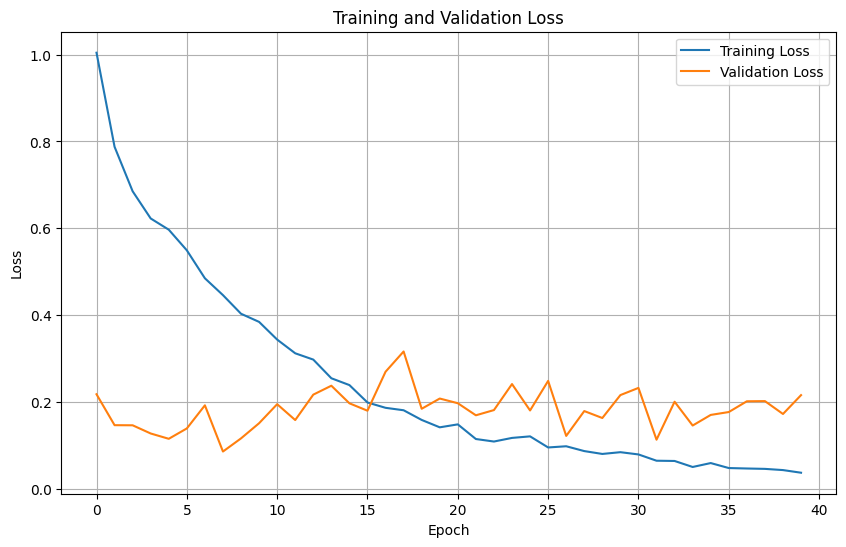

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()